In [1]:
!pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools;

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_labels_paper import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
BATCH_SIZE = 32
LAST_DENSE = 1024
SOFTMAX_OUT = True
FROM_LOGITS = False
LEARNING_RATE = 0.0001
INFO = "-"

CONFIG_STRING = "batch_size: {0} | last_dense: {1} | softmax: {2} | from_logits: {3} | lr: {4} | info: {5}"

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [8]:
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, anchor, validation):
        return tf.math.abs(anchor - validation)

class ResNet34:
    def __init__(self, input_shape=(224,224,3)):
        self.input_shape = input_shape
        self.model = self.CreateFeatureExtractor()

    def IdentityBlock(self, input, filters):
        conv1 = Conv2D(filters, (3,3), padding="same")(input)
        batchnorm1 = BatchNormalization(axis=3)(conv1)
        relu1 = ReLU()(batchnorm1)

        conv2 = Conv2D(filters, (3,3), padding="same")(relu1)
        batchnorm2 = BatchNormalization(axis=3)(conv2)

        add = Add()([batchnorm2,input])
        relu2 = ReLU()(add)
        return relu2

    def ConvolutionBlock(self, input, filters):
        conv1 = Conv2D(filters, (3,3), padding="same", strides=(2,2))(input)
        batchnorm1 = BatchNormalization(axis=3)(conv1)
        relu1 = ReLU()(batchnorm1)

        conv2 = Conv2D(filters, (3,3), padding="same")(relu1)
        batchnorm2 = BatchNormalization(axis=3)(conv2)

        linear_proj = Conv2D(filters, (1,1), strides=(2,2))(input)

        add = Add()([batchnorm2, linear_proj])
        relu2 = ReLU()(add)
        return relu2

    def CreateFeatureExtractor(self):
        input = Input(shape=self.input_shape)
        x = ZeroPadding2D((3,3))(input)
        x = Conv2D(64, (7,7), strides=(2,2))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)

        x = self.IdentityBlock(x, 64)
        x = self.IdentityBlock(x, 64)
        x = self.IdentityBlock(x, 64)
        x = self.ConvolutionBlock(x, 128)
        x = self.IdentityBlock(x, 128)
        x = self.IdentityBlock(x, 128)
        x = self.IdentityBlock(x, 128)
        x = self.ConvolutionBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.ConvolutionBlock(x, 512)
        x = self.IdentityBlock(x, 512)
        x = self.IdentityBlock(x, 512)
        x = GlobalAveragePooling2D()(x)
        x = Flatten()(x)
        x = Dense(LAST_DENSE, activation="relu")(x)
        return Model(inputs=[input], outputs=[x], name='embedding')


def SiameseNetwork(input_shape, embedding):
    anchor = Input(name='anchor', shape=input_shape)
    validation = Input(name='validation', shape=input_shape)

    distances = DistanceLayer()(embedding(anchor),embedding(validation))
    classifier = Dense(1, activation='sigmoid')(distances)
    siamese_network = Model(inputs=[anchor, validation], outputs=classifier)
    return siamese_network


feature_extractor = ResNet34()
siamese_network = SiameseNetwork((224,224,3), feature_extractor.model)
siamese_network.compile(optimizer=Adam(0.0001))
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 1024)         21831936    ['anchor[0][0]',                 
                                                                  'validation[0][0]']         

In [9]:
anchors = None
positives = None
negatives = None

for c in coco_labels:
    if len(os.listdir(f'coco_onehot_data/{c}')) > 0:
        files = tf.data.Dataset.list_files(f'coco_onehot_data/{c}/*').take(-1)
        others = [f'coco_onehot_data/{x}/*' for x in os.listdir(f'coco_onehot_data') if x != c]
        otherdata = tf.data.Dataset.list_files(others).take(-1)
        half = int(len(files)/2)
        a = files.take(half)
        b = files.skip(half).take(half)
        c = otherdata.take(half)
        print(f'{len(a)} : {len(b)} : {len(c)}')

        if anchors is None:
            anchors = a
            positives = b
            negatives = c
        else:
            anchors = anchors.concatenate(a)
            positives = positives.concatenate(b)
            negatives = negatives.concatenate(c)



63994 : 63994 : 63994


In [45]:
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = img/255
    return img

def preprocess_triples(anchor, positive, negative):
    return (load_images(anchor), load_images(positive), load_images(negative))

In [48]:
dataset = tf.data.Dataset.zip((anchors, positives, negatives))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triples)

imagecount = len(anchors)
train_dataset = dataset.take(round(imagecount * 0.9))
val_dataset = dataset.skip(round(imagecount * 0.9))

print(f'{len(train_dataset)} : {len(val_dataset)}')

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(8)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(8)

371132 : 41237


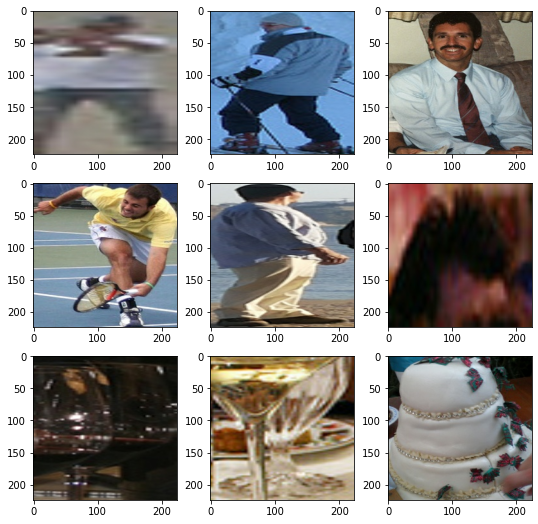

In [66]:
img_batch = next(iter(train_dataset))

fig = plt.pyplot.figure(figsize=(9,9))
axs = fig.subplots(3,3)

for i in range(3):
    axs[i, 0].imshow(img_batch[i][0])
    axs[i, 1].imshow(img_batch[i][1])
    axs[i, 2].imshow(img_batch[i][2])

In [8]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/resnet34

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/resnet34/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16084), started 4 days, 23:39:22 ago. (Use '!kill 16084' to kill it.)

In [67]:
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
11598/11598 [==============================] - ETA: 0s - loss: 0.3278

In [10]:
resnet.model.save_weights(os.path.join(weight_dir, weight_file.format("_onehot")))

In [12]:

resnet.model.evaluate(validation_ds, verbose=1)


14/14 [==============================] - 2s 151ms/step - loss: 2.2457 - accuracy: 0.6529


[2.2457149028778076, 0.6528735756874084]